<h1>DSCI-552 Final Project</h1>
<br>
Name: Chih-Ken Yao
<br>
USC ID: 7958315200
<br>
Github username: chihkeny

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import splitfolders
import PIL
from tqdm.notebook import tqdm

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
import keras

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import cv2

# (d) Data Exploration and Pre-processing

In [2]:
#resize all images
size = (224,224)
orig_dir = '../data/Sport Images/'
for activity in tqdm(os.listdir(orig_dir)):
    input_folder = orig_dir+activity
    output_folder = '../data/resize/'+activity
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for file in tqdm(os.listdir(input_folder)):
        input_img = input_folder+"/"+file
        output_img = output_folder+'/'+file
        img = PIL.Image.open(input_img)
        img = img.resize(size)
        img.save(output_img)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/634 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

In [3]:
#split all data into train, val, and test
input_dir = '../data/resize/'
output_dir = '../data/split/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
splitfolders.ratio(input_dir, output=output_dir, seed=552, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 3280 files [00:12, 267.26 files/s]


In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(output_dir+'train', image_size=size, label_mode='categorical',seed=552) 
val_data = tf.keras.utils.image_dataset_from_directory(output_dir+'val', image_size=size, label_mode='categorical', seed=552) 
test_data = tf.keras.utils.image_dataset_from_directory(output_dir+'test', image_size=size, label_mode='categorical', seed=552)
train_data_ordered = tf.keras.utils.image_dataset_from_directory(output_dir+'train', image_size=size, label_mode='categorical', shuffle=False)
val_data_ordered = tf.keras.utils.image_dataset_from_directory(output_dir+'val', image_size=size, label_mode='categorical', shuffle=False) 
test_data_ordered = tf.keras.utils.image_dataset_from_directory(output_dir+'test', image_size=size, label_mode='categorical', shuffle=False)

Found 2293 files belonging to 5 classes.
Found 490 files belonging to 5 classes.
Found 496 files belonging to 5 classes.
Found 2293 files belonging to 5 classes.
Found 490 files belonging to 5 classes.
Found 496 files belonging to 5 classes.


# (e) Transfer Learning for Image Classification

In [5]:
def transfer_learning(pretrained, model_name):
    inputs = keras.layers.Input(shape=(224, 224, 3))

    augmentation = keras.Sequential(
        [
            keras.layers.RandomCrop(224,224),
            keras.layers.RandomFlip("horizontal"),
            keras.layers.RandomZoom(height_factor=(-0.1,0.1)),
            keras.layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
            keras.layers.RandomRotation(factor=(-0.1, 0.1)),
            keras.layers.RandomContrast(factor=0.1)
        ],
        name="image_augmentation")

    outputs = keras.Sequential(
        [
            keras.layers.Dense(5, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.20),
            keras.layers.Dense(5, activation='softmax')
        ],
        name = "outputs"
    )


    model = keras.Sequential(
        [
            inputs,
            augmentation,
            pretrained,
            outputs
        ], 
        name = model_name
    )

    print(model.summary())
    print(model.output_shape)

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    results = model.fit(train_data, epochs=100, callbacks=[earlystop], batch_size=5, validation_data=val_data)

    plt.plot(results.history["accuracy"])
    plt.plot(results.history["val_accuracy"])
    plt.title(model_name + " accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"])
    plt.show()
    
    return model, results

In [6]:
labels = ['baseball','basketball','fencing','tennis','volleyball']
def stats(_model, data):
    pred = _model.predict(data)
    y_true = np.concatenate([y for x, y in data], axis=0)
    y_pred = np.zeros_like(pred)
    y_pred[np.arange(len(pred)), pred.argmax(1)] = 1
    
    y_true_labels = []
    for y in y_true:
        for i in range(len(y)):
            if y[i] == 1: 
                y_true_labels.append(labels[i])
            
    y_pred_labels = []
    for y in y_pred:
        for i in range(len(y)):
            if y[i] == 1: 
                y_pred_labels.append(labels[i])
    
    print()
    print("Multilabel Confusion Matrix:")
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    print(cm)
    
    print()
    print("Classification Report:")
    report = classification_report(y_true_labels, y_pred_labels)
    print(report)

In [7]:
def print_stats(_model):
    print("-------------------------------------------------------")
    print("train data:")
    stats(_model, train_data_ordered)
    print("-------------------------------------------------------")
    print("-------------------------------------------------------")
    print("test data:")
    stats(_model, test_data_ordered)
    print("-------------------------------------------------------")

## ResNet50

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_augmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 outputs (Sequential)        (None, 5)                 5055      
                                                                 
Total params: 25,641,767
Trainable params: 2,054,045
Non-trainable params: 23,587,722
_________________________________________________________________
None
(None, 5)
Epoch 1/100
72/72 [==============================] - 117s 2s/step - loss: 1.3187 - accuracy: 0.4963 - val_loss: 1.5426 - val_accuracy: 0.6735
Epoch 2/100
72/72 [==============================] - 113s 2s/step - loss: 0.899

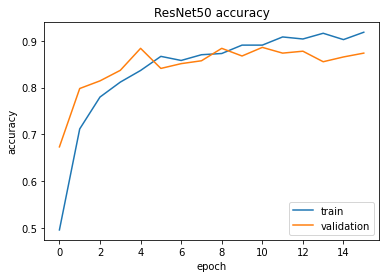

In [8]:
res = ResNet50(weights='imagenet', include_top=True)
for layer in res.layers[:-1]:
    layer.trainable = False

res_model, res_result = transfer_learning(res, "ResNet50")

In [9]:
print_stats(res_model)

-------------------------------------------------------
train data:
72/72 [==============================] - 95s 1s/step

Multilabel Confusion Matrix:
[[508   1   4   1   0]
 [ 15 301   8   6  14]
 [  4   0 433   2   4]
 [ 17   1  11 469   2]
 [ 11   1  15   1 464]]

Classification Report:
              precision    recall  f1-score   support

    baseball       0.92      0.99      0.95       514
  basketball       0.99      0.88      0.93       344
     fencing       0.92      0.98      0.95       443
      tennis       0.98      0.94      0.96       500
  volleyball       0.96      0.94      0.95       492

    accuracy                           0.95      2293
   macro avg       0.95      0.94      0.95      2293
weighted avg       0.95      0.95      0.95      2293

-------------------------------------------------------
-------------------------------------------------------
test data:
16/16 [==============================] - 21s 1s/step

Multilabel Confusion Matrix:
[[102   2   3 

## EfficientNetB0

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_augmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 outputs (Sequential)        (None, 5)                 5055      
                                                                 
Total params: 5,335,626
Trainable params: 1,286,045
Non-trainable params: 4,049,581
_________________________________________________________________
None
(None, 5)
Epoch 1/100
72/72 [==============================] - 83s 1s/step - loss: 1.0745 - accuracy: 0.6533 - val_loss: 1.4928 - val_accuracy: 0.4184
Epoch 2/100
72/72 [==============================] - 76s 1s/step - loss: 0.6

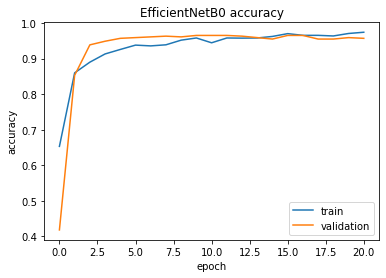

In [10]:
enb = EfficientNetB0(weights='imagenet', include_top=True)
for layer in enb.layers[:-1]:
    layer.trainable = False

enb_model, enb_result = transfer_learning(enb, 'EfficientNetB0')

In [11]:
print_stats(enb_model)

-------------------------------------------------------
train data:
72/72 [==============================] - 55s 744ms/step

Multilabel Confusion Matrix:
[[514   0   0   0   0]
 [  1 337   0   0   6]
 [  0   0 443   0   0]
 [  0   0   0 500   0]
 [  1   0   0   1 490]]

Classification Report:
              precision    recall  f1-score   support

    baseball       1.00      1.00      1.00       514
  basketball       1.00      0.98      0.99       344
     fencing       1.00      1.00      1.00       443
      tennis       1.00      1.00      1.00       500
  volleyball       0.99      1.00      0.99       492

    accuracy                           1.00      2293
   macro avg       1.00      1.00      1.00      2293
weighted avg       1.00      1.00      1.00      2293

-------------------------------------------------------
-------------------------------------------------------
test data:
16/16 [==============================] - 11s 679ms/step

Multilabel Confusion Matrix:
[[103   

## VGG16

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_augmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 outputs (Sequential)        (None, 5)                 5055      
                                                                 
Total params: 138,362,599
Trainable params: 4,102,045
Non-trainable params: 134,260,554
_________________________________________________________________
None
(None, 5)
Epoch 1/100
72/72 [==============================] - 202s 3s/step - loss: 1.2816 - accuracy: 0.5146 - val_loss: 1.5524 - val_accuracy: 0.5020
Epoch 2/100
72/72 [==============================] - 200s 3s/step - loss: 1.0427

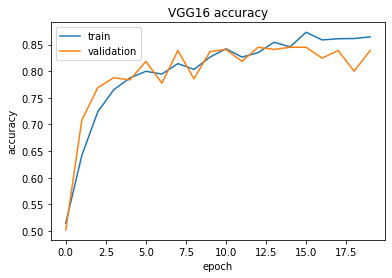

In [12]:
vgg = VGG16(weights="imagenet", include_top=True)
for layer in vgg.layers[:-1]:
    layer.trainable = False 

vgg_model, vgg_result = transfer_learning(vgg, "VGG16")

In [13]:
print_stats(vgg_model)

-------------------------------------------------------
train data:
72/72 [==============================] - 159s 2s/step

Multilabel Confusion Matrix:
[[469   5  18  17   5]
 [  0 303   9   8  24]
 [  5   1 418  14   5]
 [ 15   4   9 464   8]
 [  5   7  21  10 449]]

Classification Report:
              precision    recall  f1-score   support

    baseball       0.95      0.91      0.93       514
  basketball       0.95      0.88      0.91       344
     fencing       0.88      0.94      0.91       443
      tennis       0.90      0.93      0.92       500
  volleyball       0.91      0.91      0.91       492

    accuracy                           0.92      2293
   macro avg       0.92      0.92      0.92      2293
weighted avg       0.92      0.92      0.92      2293

-------------------------------------------------------
-------------------------------------------------------
test data:
16/16 [==============================] - 35s 2s/step

Multilabel Confusion Matrix:
[[94  2  7  5

# (f) Video Classification Using Moving Averages

In [28]:
combined_data = train_data.concatenate(val_data).concatenate(test_data)
video_labels = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']

In [15]:
# reuse train+val+test data fit till previous epochs
def transfer_learning_retrain(pretrained, model_name, prev_epochs):
    inputs = keras.layers.Input(shape=(224, 224, 3))

    augmentation = keras.Sequential(
        [
            keras.layers.RandomCrop(224,224),
            keras.layers.RandomFlip("horizontal"),
            keras.layers.RandomZoom(height_factor=(-0.1,0.1)),
            keras.layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1,0.1)),
            keras.layers.RandomRotation(factor=(-0.1, 0.1)),
            keras.layers.RandomContrast(factor=0.1)
        ],
        name="image_augmentation")

    outputs = keras.Sequential(
        [
            keras.layers.Dense(5, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.20),
            keras.layers.Dense(5, activation='softmax')
        ],
        name = "outputs"
    )


    model = keras.Sequential(
        [
            inputs,
            augmentation,
            pretrained,
            outputs
        ], 
        name = model_name
    )

    print(model.summary())
    print(model.output_shape)

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    results = model.fit(combined_data, epochs=prev_epochs, batch_size=5)
    
    return model, results

In [16]:
def getLabelOfVideo(path, model, n=100):
    vid = cv2.VideoCapture(path)
    total_frames = vid.get(cv2.CAP_PROP_FRAME_COUNT)
    frames_step = total_frames//n
    imgs = np.zeros((n,224,224,3))
    labs = np.zeros((n, 5))
    for i in range(n):
        vid.set(1, i*frames_step)
        _, image = vid.read()
        resized = cv2.resize(image, size)
        imgs[i] = resized
        
    d = tf.data.Dataset.from_tensor_slices((imgs, labs)).batch(5)
    pred = model.predict(d, verbose=0)
    pred = pred.mean(axis=0)
    y_pred = np.zeros_like(pred)
    y_pred[pred.argmax()] = 1
    for i in range(5):
            if y_pred[i] == 1: 
                lab = labels[i]
                
    return lab

In [17]:
def getLabels(model):
    video_path = '../data/Sport Videos/'
    y_true = []
    y_pred = []
    for activity in tqdm(os.listdir(video_path)):
        input_folder = video_path+activity
        for file in tqdm(os.listdir(input_folder)):
            file_path = input_folder + '/' + file
            y_true.append(labels[video_labels.index(activity)])
            y_pred.append(getLabelOfVideo(file_path, model))
    return y_true, y_pred

In [18]:
def video_stats(y_true, y_pred):
    print()
    print("Multilabel Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    print()
    print("Classification Report:")
    report = classification_report(y_true, y_pred)
    print(report)

# ResNet50

In [29]:
res_prev_epochs = len(res_result.history['loss'])
new_res_model, new_res_result = transfer_learning_retrain(res, "ResNet50", res_prev_epochs)

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_augmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 outputs (Sequential)        (None, 5)                 5055      
                                                                 
Total params: 25,641,767
Trainable params: 2,054,045
Non-trainable params: 23,587,722
_________________________________________________________________
None
(None, 5)
Epoch 1/16
104/104 [==============================] - 135s 1s/step - loss: 1.0727 - accuracy: 0.6810
Epoch 2/16
104/104 [==============================] - 138s 1s/step - loss: 0.7485 - accuracy: 0.8210
Epoch 3/16
104/104 

In [30]:
y_true_res, y_pred_res = getLabels(new_res_model)
video_stats(y_true_res, y_pred_res)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]


Multilabel Confusion Matrix:
[[118   0   1  31   0]
 [ 25   0  24  67  21]
 [ 19   0  92   0   0]
 [ 10   0   0 157   0]
 [  0   0  77  15  24]]

Classification Report:
              precision    recall  f1-score   support

    baseball       0.69      0.79      0.73       150
  basketball       0.00      0.00      0.00       137
     fencing       0.47      0.83      0.60       111
      tennis       0.58      0.94      0.72       167
  volleyball       0.53      0.21      0.30       116

    accuracy                           0.57       681
   macro avg       0.46      0.55      0.47       681
weighted avg       0.46      0.57      0.49       681



C:\Users\iveny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iveny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\iveny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# EfficientNetB0

In [31]:
enb_prev_epochs = len(enb_result.history['loss'])
new_enb_model, new_enb_result = transfer_learning_retrain(enb, "EfficientNetB0", enb_prev_epochs)

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_augmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 outputs (Sequential)        (None, 5)                 5055      
                                                                 
Total params: 5,335,626
Trainable params: 1,286,045
Non-trainable params: 4,049,581
_________________________________________________________________
None
(None, 5)
Epoch 1/21
104/104 [==============================] - 88s 797ms/step - loss: 1.1093 - accuracy: 0.6060
Epoch 2/21
104/104 [==============================] - 83s 796ms/step - loss: 0.5814 - accuracy: 0.8963
Epoch 3/21


In [32]:
y_true_enb, y_pred_enb = getLabels(new_enb_model)
video_stats(y_true_enb, y_pred_enb)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]


Multilabel Confusion Matrix:
[[ 97   0  12  37   4]
 [  0   3  38  74  22]
 [  0   0 107   4   0]
 [ 19   0   7 138   3]
 [  1   0  61   7  47]]

Classification Report:
              precision    recall  f1-score   support

    baseball       0.83      0.65      0.73       150
  basketball       1.00      0.02      0.04       137
     fencing       0.48      0.96      0.64       111
      tennis       0.53      0.83      0.65       167
  volleyball       0.62      0.41      0.49       116

    accuracy                           0.58       681
   macro avg       0.69      0.57      0.51       681
weighted avg       0.70      0.58      0.51       681



# VGG16

In [33]:
vgg_prev_epochs = len(vgg_result.history['loss'])
new_vgg_model, new_vgg_result = transfer_learning_retrain(vgg, "VGG16", vgg_prev_epochs)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_augmentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 outputs (Sequential)        (None, 5)                 5055      
                                                                 
Total params: 138,362,599
Trainable params: 4,102,045
Non-trainable params: 134,260,554
_________________________________________________________________
None
(None, 5)
Epoch 1/20
104/104 [==============================] - 327s 3s/step - loss: 1.4360 - accuracy: 0.3532
Epoch 2/20
104/104 [==============================] - 331s 3s/step - loss: 1.1380 - accuracy: 0.5410
Epoch 3/20
104/104 [

In [34]:
y_true_vgg, y_pred_vgg = getLabels(new_vgg_model)
video_stats(y_true_vgg, y_pred_vgg)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]


Multilabel Confusion Matrix:
[[110   0   6  34   0]
 [  0   1  63  55  18]
 [  0   0 109   1   1]
 [  1   0  26 133   7]
 [  0   0  70  15  31]]

Classification Report:
              precision    recall  f1-score   support

    baseball       0.99      0.73      0.84       150
  basketball       1.00      0.01      0.01       137
     fencing       0.40      0.98      0.57       111
      tennis       0.56      0.80      0.66       167
  volleyball       0.54      0.27      0.36       116

    accuracy                           0.56       681
   macro avg       0.70      0.56      0.49       681
weighted avg       0.71      0.56      0.50       681

